<a href="https://colab.research.google.com/github/good5229/DeepLearning_Project/blob/main/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd

import torch
import torchvision

from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import RandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import cv2
import time
import itertools
import os
from PIL import Image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Cleansed_and_removed/

#경로 확인
!pwd

/content/drive/MyDrive/Cleansed_and_removed
/content/drive/MyDrive/Cleansed_and_removed


# 훈련용 이미지와 테스트용 이미지 분리

In [ ]:
df = pd.read_csv('./preprocessed_art.csv')
df = df.drop('Unnamed: 0', axis=1)
print(len(df))
df.head()

22444


,index,title,author,year,standard,genre,technique,source,date,price,...,MSCI_world_MACD,One_year_bond_momentum,One_year_bond_RSI,One_year_bond_MACD,Gold_momentum,Gold_RSI,Gold_MACD,VIX_momentum,VIX_RSI,VIX_MACD
0,71,무제,1,2003,60.5×91cm,0,캔버스에 유채,1,2021-06-03,18000000,...,-13.005561,0.205508,0.097902,-0.040734,-0.022622,0.398363,26.361374,-0.022622,0.398363,26.361374
1,72,무제,1,2003,27×23cm,0,"종이에 수묵, 수채",0,2021-05-24,1100000,...,-15.280810,0.252033,0.589744,-0.053255,-0.049933,0.137980,23.169392,-0.049933,0.137980,23.169392
2,73,청호박과 호박꽃,1,2002,53×72.7cm,0,캔버스에 아크릴릭,0,2021-04-28,25000000,...,-8.150539,-0.025714,0.560976,0.000158,0.056889,0.398558,-21.732597,0.056889,0.398558,-21.732597
3,74,가을연꽃,1,2007,72.5×49.5cm,0,캔버스에 아크릴릭,1,2021-04-27,17500000,...,-6.991066,0.000000,0.322581,0.000705,0.061353,0.410293,-22.180523,0.061353,0.410293,-22.180523
4,75,만년일파,1,2012,91×116.8cm,0,캔버스에 아크릴릭,0,2020-11-25,20000000,...,-25.257254,-0.025806,0.480000,0.006673,0.059156,0.800358,-16.623125,0.059156,0.800358,-16.623125


In [ ]:
mask_1 = (df['date'] >= '2016-01-01') & (df['date'] <= '2020-12-31')
df_train = df.loc[mask_1]
df_train = df_train.reset_index()

mask_2 = (df['date'] >= '2021-01-01')
df_test = df.loc[mask_2]
df_test = df_test.reset_index()

print(len(df_train), len(df_test))

18403 2802


In [ ]:
mask_false = (df['date'] <= '2015-12-31')
df_false = df.loc[mask_false]
df_false

,index,title,author,year,standard,genre,technique,source,date,price,...,MSCI_world_MACD,One_year_bond_momentum,One_year_bond_RSI,One_year_bond_MACD,Gold_momentum,Gold_RSI,Gold_MACD,VIX_momentum,VIX_RSI,VIX_MACD
40,111,보리밭,1,2007,112.1×162.2cm,0,캔버스에 아크릴릭,0,2015-12-30,30000000,...,28.983204,-0.105691,0.736264,0.023887,0.113604,0.566325,-24.327257,0.113604,0.566325,-24.327257
41,112,삼태성,1,2007,162×130.2cm,0,캔버스에 아크릴릭,1,2015-12-16,60000000,...,27.439848,-0.058380,0.591954,0.027949,0.046775,0.526238,-14.918292,0.046775,0.526238,-14.918292
42,113,썰물,1,1994,72.8×116.8cm,0,캔버스에 유채,1,2015-12-16,23000000,...,27.439848,-0.058380,0.591954,0.027949,0.046775,0.526238,-14.918292,0.046775,0.526238,-14.918292
43,117,텃밭,1,1991,44×74cm,0,캔버스에 유채,0,2015-11-10,4500000,...,7.736406,0.010385,0.045455,-0.005680,-0.016366,0.923566,2.159048,-0.016366,0.923566,2.159048
44,118,용폭,1,2005,227×181.6cm,0,캔버스에 아크릴릭,1,2015-09-15,60000000,...,-8.332418,0.018100,0.750000,-0.005974,0.052744,0.538204,-4.488522,0.052744,0.538204,-4.488522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22439,29013,새벽 눈,158,1998,53×72.7cm,0,캔버스에 유채,0,2015-12-30,9500000,...,28.983204,-0.105691,0.736264,0.023887,0.113604,0.566325,-24.327257,0.113604,0.566325,-24.327257
22440,29014,풍경(선탄장),158,1986,72.7×60.5cm,0,캔버스에 유채,1,2015-12-16,15000000,...,27.439848,-0.058380,0.591954,0.027949,0.046775,0.526238,-14.918292,0.046775,0.526238,-14.918292
22441,29015,풍경,158,1986,72.8×91cm,0,캔버스에 유채,1,2015-12-16,15000000,...,27.439848,-0.058380,0.591954,0.027949,0.046775,0.526238,-14.918292,0.046775,0.526238,-14.918292
22442,29016,고무 씹기,158,2008,72.2×60cm,0,캔버스에 유채,1,2015-06-16,45000000,...,9.338563,-0.034069,0.688000,0.010046,-0.078979,0.523847,15.606383,-0.078979,0.523847,15.606383


In [ ]:
false_list = list(df_false['index'].values)
len(false_list)

1239

In [ ]:
image_path = './'
file_list = os.listdir(image_path)
print(len(file_list))

4


In [ ]:
def file_split():
    file_idx_list = set()
    for file in file_list:
        if file.endswith('.png'):
            file_idx = file.split('_')[0]
            file_idx_list.add(int(file_idx))


    false_list = list(map(int, false_list))
    type(false_list[0])

    file_source = './'
    file_destination = './unused/'
    counter = 0
    for idx in false_list:
        for file in file_list:
            if str(idx)==file.split('_')[0]:
                counter+=1
                # print(file)
                os.replace(file_source + file, file_destination + file)
    train_list = list(df_train['index'].values)
    train_list = list(map(int, train_list))
    print(len(train_list))

    file_source = './'
    file_destination = './train/'
    counter = 0
    for idx in train_list:
        for file in file_list:
            if str(idx)==file.split('_')[0]:
                counter+=1
                # print(file)
                os.replace(file_source + file, file_destination + file)

    test_list = list(df_test['index'].values)
    test_list = list(map(int, test_list))
    print(len(test_list))

    file_source = './'
    file_destination = './test/'
    counter = 0
    for idx in test_list:
        for file in file_list:
            if str(idx)==file.split('_')[0]:
                counter+=1
                # print(file)
                os.replace(file_source + file, file_destination + file)

int

In [ ]:
false_image_path = './unused/'
false_file_list = os.listdir(false_image_path)

train_image_path = './train/'
train_file_list = os.listdir(train_image_path)

test_image_path = './test/'
test_file_list = os.listdir(test_image_path)

In [ ]:
def matching_url():
    df_train['URL'] = ''
    df_test['URL'] = ''
    train_count = 0
    for i in range(len(df_train)):
        idx = df_train['index'][i]
        for file in train_file_list:
            if file.split('_')[0]==str(idx):
                df_train['URL'][i] = f'./train/{file}'
                train_count+=1

    test_count = 0
    for i in range(len(df_test)):
        idx = df_test['index'][i]
        for file in test_file_list:
            if file.split('_')[0]==str(idx):
                df_test['URL'][i] = f'./test/{file}'
                test_count+=1

    print(train_count, test_count)

In [ ]:
df_train.to_csv('./df_train.csv', encoding='utf-8-sig')
df_test.to_csv('./df_test.csv', encoding='utf-8-sig')

# 데이터 호출

In [ ]:
df_train = pd.read_csv('./df_train.csv')
df_test = pd.read_csv('./df_test.csv')

# cnn_df_train = df_train.loc[:, ['index', 'classify_3', 'price', 'URL']]
# cnn_df_test = df_test.loc[:, ['index', 'classify_3', 'price', 'URL']]
cnn_df_train = pd.read_csv('./cnn_df_train.csv')
cnn_df_test = pd.read_csv('./cnn_df_test.csv')
cnn_df_test

,Unnamed: 0,index,classify_3,price,URL
0,0,71,3,18000000,./test/resized/71_무제_강요배_2003.png
1,1,72,1,1100000,./test/resized/72_무제_강요배_2003.png
2,2,73,3,25000000,./test/resized/73_청호박과호박꽃_강요배_2...
3,3,74,3,17500000,./test/resized/74_가을연꽃_강요배_2007.png
4,4,121,3,16000000,./test/resized/121_HappyWorldHG30J_강익중_.png
...,...,...,...,...,...
2797,2797,28969,3,60000000,./test/resized/28969_선탄부II_황재형_1985.png
2798,2798,28970,3,11000000,./test/resized/28970_남겨진것_황재형_2001...
2799,2799,28972,3,45000000,./test/resized/28972_외줄타기_황재형_1996~2...
2800,2800,28973,3,30000000,./test/resized/28973_사택뒤켠_황재형_1997.png


# 이미지 전처리

선행논문에서는 128x128 사이즈로 이미지 파일을 변형했다고 명시되어 있다.
이미지 파일을 128x128 사이즈로 변형해서 저장하자.

18403
2802


In [ ]:
cnn_df_train

,index,classify_3,price,URL
0,75,3,20000000,./train/75_만년일파_강요배_2012.png
1,76,3,21000000,./train/76_귀면암_강요배_1999.png
2,77,3,30000000,./train/77_물매화_강요배_2001.png
3,78,3,46000000,./train/78_풍경_강요배_2007.png
4,79,3,28000000,./train/79_풍경_강요배_2003.png
...,...,...,...,...
18398,29008,3,30000000,./train/29008_어스름_황재형_1995~2001.png
18399,29009,2,2800000,./train/29009_광부의일기중에서_황재형_198...
18400,29010,2,8000000,./train/29010_겨울사북_황재형_1984.png
18401,29011,3,40000000,./train/29011_외줄타기_황재형_1996~2007.png


In [ ]:
def resize():
    test_img_url = list(cnn_df_test['URL'])
    train_img_url = list(cnn_df_train['URL'])
    size = 128
    for file in train_img_url:
        try:
            img = Image.open(file)
            img_resize = img.resize((size, size), Image.LANCZOS)
            title, ext = os.path.splitext(file)
            title = title.split('/')[2]
            # print(title, ext)
            img_resize.save(f'./train/resized/'+title + ext)
        except OSError as e:
            pass

    for file in test_img_url:
        try:
            img = Image.open(file)
            img_resize = img.resize((size, size), Image.LANCZOS)
            title, ext = os.path.splitext(file)
            title = title.split('/')[2]
            # print(title, ext)
            img_resize.save(f'./test/resized/'+title + ext)
        except OSError as e:
            pass

    train_resized_image_path = './train/resized/'
    train_resized_file_list = os.listdir(train_resized_image_path)
    print(len(train_resized_file_list))

    test_resized_image_path = './test/resized/'
    test_resized_file_list = os.listdir(test_resized_image_path)
    print(len(test_resized_file_list))

def change_url():
    for i in range(len(cnn_df_train)):
        ori_text = cnn_df_train['URL'][i]
        url = ori_text[:8]
        filename = ori_text[8:]
        new_url = ori_text[:8]+'resized/'+filename
        cnn_df_train['URL'][i] = new_url

    for i in range(len(cnn_df_test)):
        ori_text = cnn_df_test['URL'][i]
        url = ori_text[:]
        filename = ori_text[7:]
        new_url = ori_text[:7]+'resized/'+filename
        cnn_df_test['URL'][i] = new_url

cnn_df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,classify_3,price,URL
0,71,3,18000000,./test/resized/71_무제_강요배_2003.png
1,72,1,1100000,./test/resized/72_무제_강요배_2003.png
2,73,3,25000000,./test/resized/73_청호박과호박꽃_강요배_2...
3,74,3,17500000,./test/resized/74_가을연꽃_강요배_2007.png
4,121,3,16000000,./test/resized/121_HappyWorldHG30J_강익중_.png
...,...,...,...,...
2797,28969,3,60000000,./test/resized/28969_선탄부II_황재형_1985.png
2798,28970,3,11000000,./test/resized/28970_남겨진것_황재형_2001...
2799,28972,3,45000000,./test/resized/28972_외줄타기_황재형_1996~2...
2800,28973,3,30000000,./test/resized/28973_사택뒤켠_황재형_1997.png


In [ ]:
cnn_df_train.to_csv('./cnn_df_train.csv', encoding='utf-8-sig')
cnn_df_test.to_csv('./cnn_df_test.csv', encoding='utf-8-sig')

# 파이토치 코드 작성

https://blog.promedius.ai/pytorch_dataloader_1/

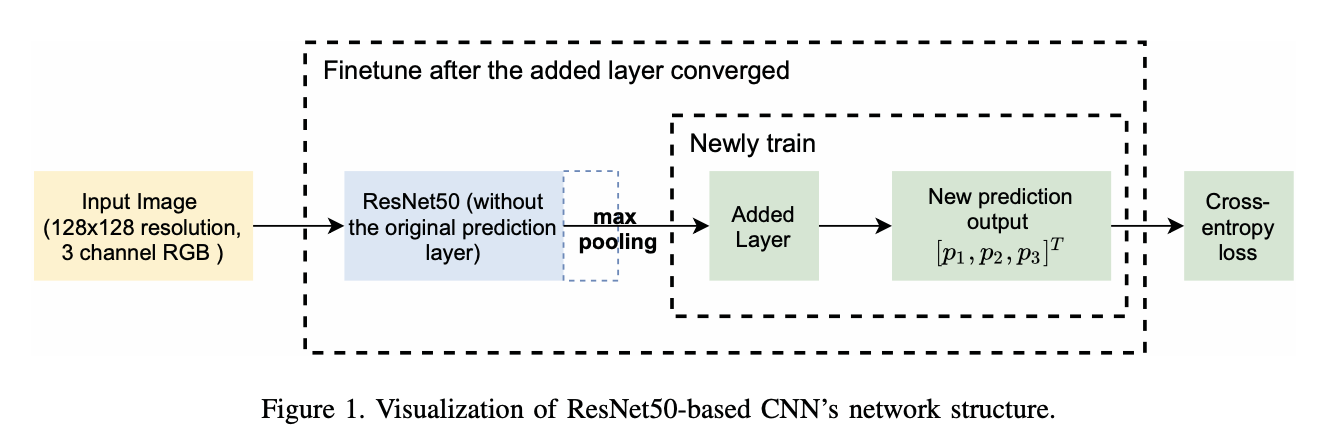

In [ ]:
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

class Img_Dataset(Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        return img_transformed

train_img_list= list(cnn_df_train['URL'])

mean = (0.5,)
std = (0.3,)

train_dataset = Img_Dataset(file_list=train_img_list,
                            transform=ImageTransform(mean, std))

train_dataloader = data.DataLoader(train_dataset,
                                   batch_size=64,
                                   shuffle=True)

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

print(images.size())

NameError: ignored

## Classification

In [ ]:
classes = 4
train_img = list(cnn_df_train['URL'])

def get_transform():
    return T.Compose([T.ToTensor()])

class BirdDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Retriving class label
        label = cnn_df_train['classify_3']
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        return image, label
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [ ]:
print(type(train_img))
type(list(cnn_df_train['classify_3'])[0])

<class 'list'>


int

In [ ]:
train_dataset = BirdDataset(train_img, list(cnn_df_train['classify_3']), get_transform())
train_random_sampler = RandomSampler(train_dataset)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler = train_random_sampler,
    num_workers = 2,
)

In [ ]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

RuntimeError: ignored

In [ ]:



valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    sampler = valid_random_sampler,
    num_workers = 4,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    sampler = test_random_sampler,
    num_workers = 4,
)